### Author:  Charlie Becker
### Date: 12-03-18

This is a simple analysis on the COMPAS Recidivism Risk Scores that were contested by Pro Publica claiming that they were racially biased against the black population.  Northpoint (the creator of COMPAS) published a 37-page rebuttle refuting the bias claims defending their software.  This is a minor analysis to see if either side claims are substantiated.   

In [172]:
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import *
import seaborn as sb
from seaborn import FacetGrid, factorplot
from pylab import figure, text, scatter, show
import warnings
warnings.filterwarnings('ignore')
sb.set(font_scale=3)

Here we load the data, filter values that don't make sense and remove the columns that we don't need for analysis.

In [173]:
d = pd.read_csv("compas-scores-two-years.csv")
d = d[(d['days_b_screening_arrest'] >= -30) & (d['days_b_screening_arrest'] <= 30) & (d['is_recid'] != -1) & 
      (d['c_charge_degree'] != 'O') & (d['score_text'] != 'N/A')]

df = d.iloc[:,[5,7,8,9,11,24,33,40,43,44,51,52]]

df.loc[df['decile_score'] <  8, 'p_recid'] = 0
df.loc[df['decile_score'] >=  8, 'p_recid'] = 1
df['p_recid'] = df['p_recid'].astype(int)

df.loc[df['v_decile_score'] <  8, 'v_p_recid'] = 0
df.loc[df['v_decile_score'] >=  8, 'v_p_recid'] = 1
df['v_p_recid'] = df['v_p_recid'].astype(int)

Get the ROC and AUC values for the COMPAS prediction system and plot them - one for general recidivism and one for violent recidivism 

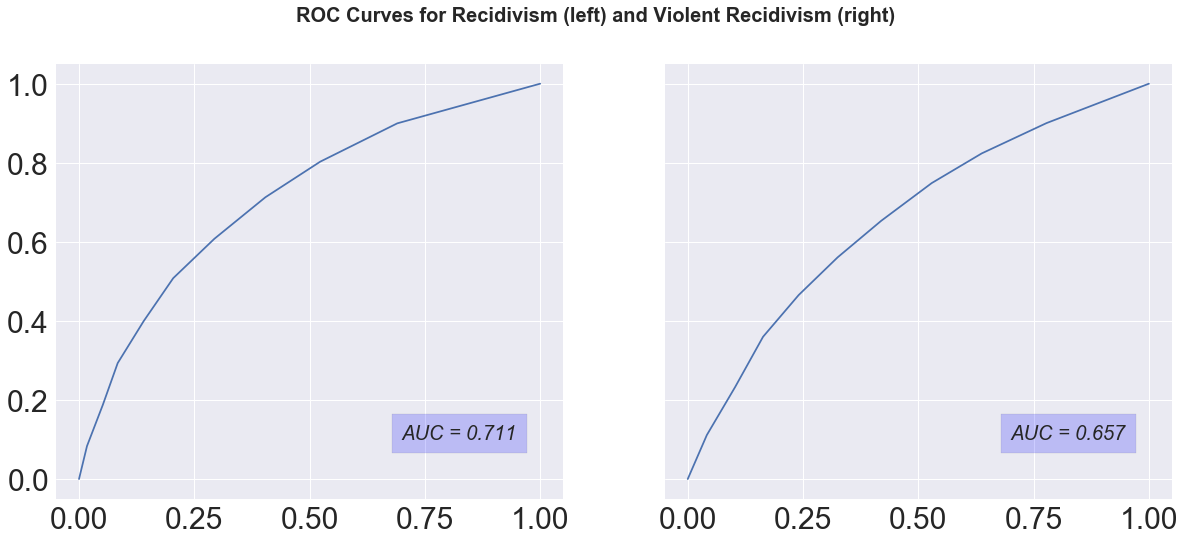

In [174]:
# get values for ROC/AUC
y_true = df['is_recid']
y_probas = df['decile_score']
fpr, tpr, thresholds = roc_curve(y_true, y_probas, pos_label=0)
y_true_v = df['is_violent_recid']
y_probas_v = df['decile_score']
fprv, tprv, thresholdsv = roc_curve(y_true_v, y_probas_v, pos_label=0)
auc = np.trapz(fpr,tpr)
aucv = np.trapz(fprv,tprv)

# plot
f, ((ax1), (ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize = (20,8))
f.suptitle('ROC Curves for Recidivism (left) and Violent Recidivism (right)', fontsize = 20, fontweight = 'bold')
ax1.plot(tpr, fpr)
ax1.text(.7, .1, 'AUC = '+ str(round(auc,3)), style='italic', fontsize = 20,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
ax2.plot(tprv,fprv)
ax2.text(.7, .1, 'AUC = '+ str(round(aucv,3)), style='italic', fontsize = 20,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
plt.show()

Pull the confusion matricies for both types of recidivism and then print the False positives, false negatives, accuracies and precision values for each

In [175]:
c = confusion_matrix(df['is_recid'],df['p_recid'])
FP = round(c[0][1]/np.sum(c)*100,2)
FN = round(c[1][0]/np.sum(c)*100,2)

cv = confusion_matrix(df['is_violent_recid'],df['v_p_recid'])
FPv = round(cv[0][1]/np.sum(cv)*100,2)
FNv = round(cv[1][0]/np.sum(cv)*100,2)

In [176]:
print("The accuracy of the recision model is: " + str(round(accuracy_score(df['p_recid'],df['is_recid']),3)*100) + "%")
print("The precision of the recision model is: " + str(round(precision_score(df['p_recid'],df['is_recid']),3)*100) + "%")
print("The recall of the recision model is: " + str(round(recall_score(df['p_recid'],df['is_recid']),3)*100) + "%")
print("The false positive rate of the recision model is: " + str(FP) + "%")
print("The false negative rate of the recision model is: " + str(FN) + "%")
print("")
print("The accuracy of the violent recision model is: " + str(round(accuracy_score(df['v_p_recid'],df['is_violent_recid']),3)*100) + "%")
print("The precision of the violent recision model is: " + str(round(precision_score(df['v_p_recid'],df['is_violent_recid']),3)*100) + "%")
print("The recall of the violent recision model is: " + str(round(recall_score(df['v_p_recid'],df['is_violent_recid']),3)*100) + "%")
print("The false positive rate of the violent recision model is: " + str(FPv) + "%")
print("The false negative rate of the violent recision model is: " + str(FNv) + "%")

The accuracy of the recision model is: 61.4%
The precision of the recision model is: 29.299999999999997%
The recall of the recision model is: 76.7%
The false positive rate of the recision model is: 4.33%
The false negative rate of the recision model is: 34.24%

The accuracy of the violent recision model is: 83.89999999999999%
The precision of the violent recision model is: 20.5%
The recall of the violent recision model is: 24.3%
The false positive rate of the violent recision model is: 7.16%
The false negative rate of the violent recision model is: 8.91%


Pull data for Caucasions, African-Americans and Hispanics and then group by likelihood of recidivism

In [177]:
df2 = df.loc[(df['race'] != 'Asian') & (df['race'] != 'Other') & (df['race'] != 'Native American')]
df_group = pd.DataFrame(df2.groupby(['score_text','race','is_recid'])['is_recid'].count().unstack())
df_group['total'] = df_group[0] + df_group[1]
df_group['Likelihood of Recidivism'] = df_group[1]/df_group['total']

df2v = df.loc[(df['race'] != 'Asian') & (df['race'] != 'Other') & (df['race'] != 'Native American')]
df_groupv = pd.DataFrame(df2v.groupby(['v_score_text','race','is_violent_recid'])['is_recid'].count().unstack())
df_groupv['total'] = df_groupv[0] + df_groupv[1]
df_groupv['Likelihood of Recidivism'] = df_groupv[1]/df_groupv['total']

In [178]:
p = df_group.reset_index()
p = p.iloc[:,[0,1,5]]
pv = df_groupv.reset_index()
pv = pv.iloc[:,[0,1,5]]
pp = p
pp['type'] = 'Recidivism'
ppv = pv
ppv['type'] = 'Violent Recidivism'
ppv.columns = pp.columns
P3 = pp.append(ppv)
P3.columns.values[0]='Risk Score'

Plot likelihood of recidivism for each type, by race and risk score

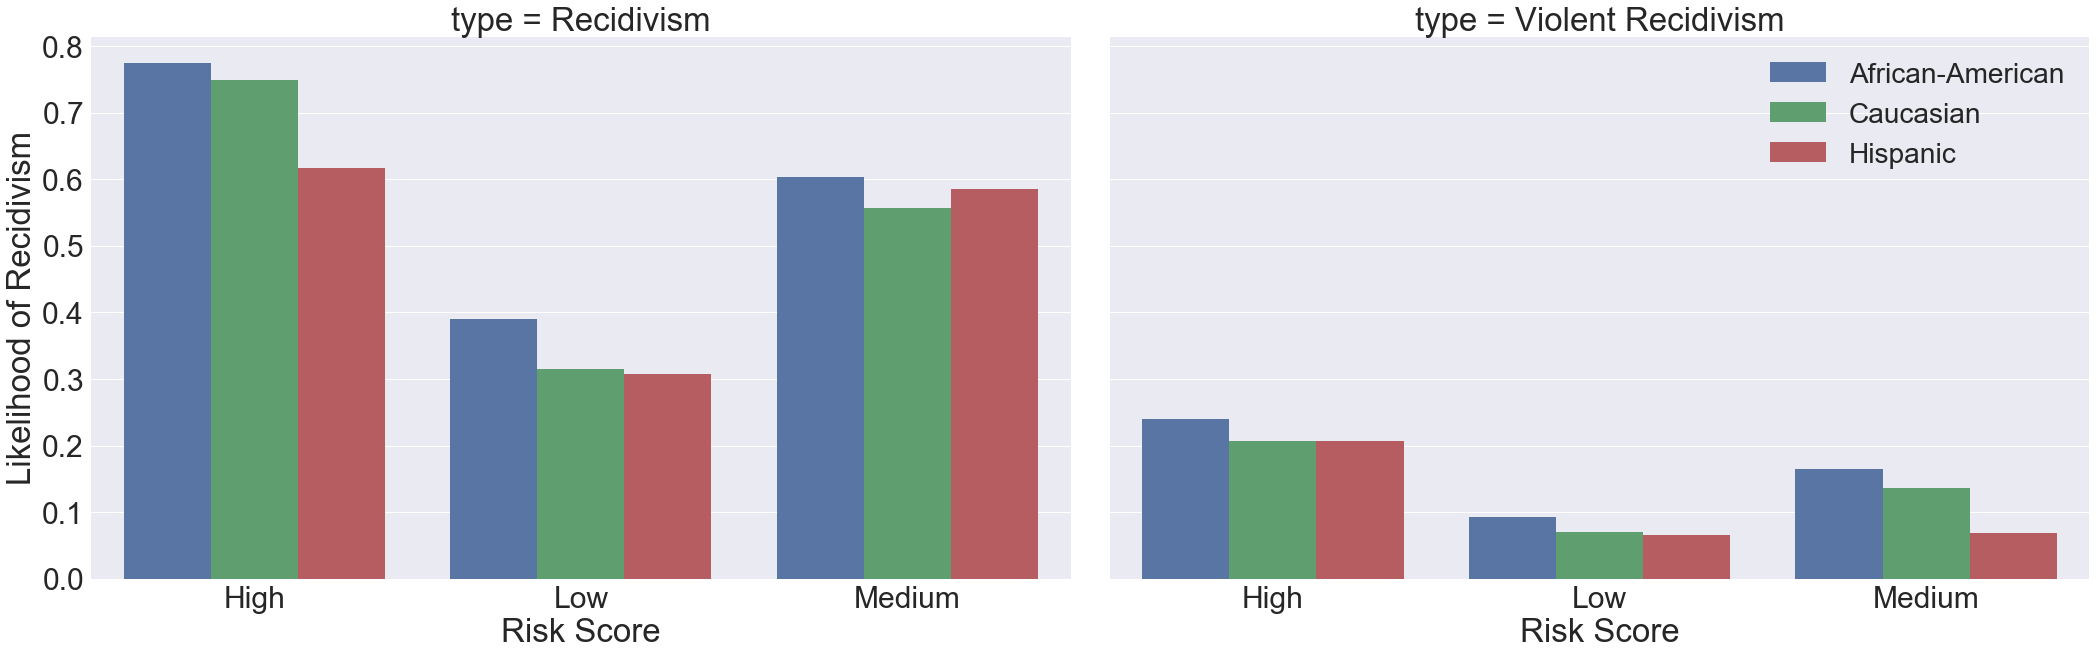

In [179]:
ax = factorplot(x='Risk Score', y='Likelihood of Recidivism', hue='race', data=P3, col = "type", kind='bar', size = 10, aspect = 1.5, 
                legend = False) 
plt.legend(loc='upper right', prop={'size': 28})
plt.show()

Create seperate dataframes for each race of interest

In [180]:
df2['high'] = 0
df2['low'] = 0
aa = df2.loc[df2.race == "African-American"]
w = df2.loc[df2.race == "Caucasian"]
h = df2.loc[df2.race == "Hispanic"]

aa.loc[aa['score_text'] ==  'High', 'high'] = 1
aa.loc[aa['score_text'] ==  'Medium', 'medium'] = 1
aa.loc[aa['score_text'] ==  'Low', 'low'] = 1

w.loc[w['score_text'] ==  'High', 'high'] = 1
w.loc[w['score_text'] ==  'Low', 'low'] = 1

h.loc[h['score_text'] ==  'High', 'high'] = 1
h.loc[h['score_text'] ==  'Low', 'low'] = 1

Get confusion matrix of each race

In [181]:
aa_low = confusion_matrix(aa.low,aa.is_recid)
aa_high = confusion_matrix(aa.high,aa.is_recid)

w_low = confusion_matrix(w.low,w.is_recid)
w_high = confusion_matrix(w.high,w.is_recid)

h_low = confusion_matrix(h.low,h.is_recid)
h_high = confusion_matrix(h.high,h.is_recid)

Calculate statistics (False Positive/Negative and precision) for each race

In [182]:
aa_high_FP, aa_low_FN = round(aa_high[1][0]/np.sum(aa_high)*100,2), round(aa_low[1][1]/np.sum(aa_low)*100,2)
w_high_FP, w_low_FN = round(w_high[1][0]/np.sum(w_high)*100,2), round(w_low[1][1]/np.sum(w_low)*100,2)
h_high_FP, h_low_FN = round(h_high[1][0]/np.sum(h_high)*100,2), round(h_low[1][1]/np.sum(h_low)*100,2)

aa_ppv = precision_score(aa['is_recid'],aa['p_recid'])*100
w_ppv = precision_score(w['is_recid'],w['p_recid'])*100
h_ppv = precision_score(h['is_recid'],h['p_recid'])*100

aa_npv, w_npv, h_npv = 100 - aa_ppv, 100 - w_ppv, 100 - h_ppv

Group False Positives/Negatives by race and plot

In [183]:
cols = ['Race','Metric', 'Score %']
x = pd.DataFrame(np.zeros((6, 3)), columns=cols)
x['Race'] = ['African-American','Hispanic','Caucasian'] * 2
x['Metric'] = ['False Positive','False Positive','False Positive','False Negative','False Negative','False Negative']
x['Score %'] = [aa_high_FP,h_high_FP,w_high_FP,aa_low_FN,h_low_FN,w_low_FN]

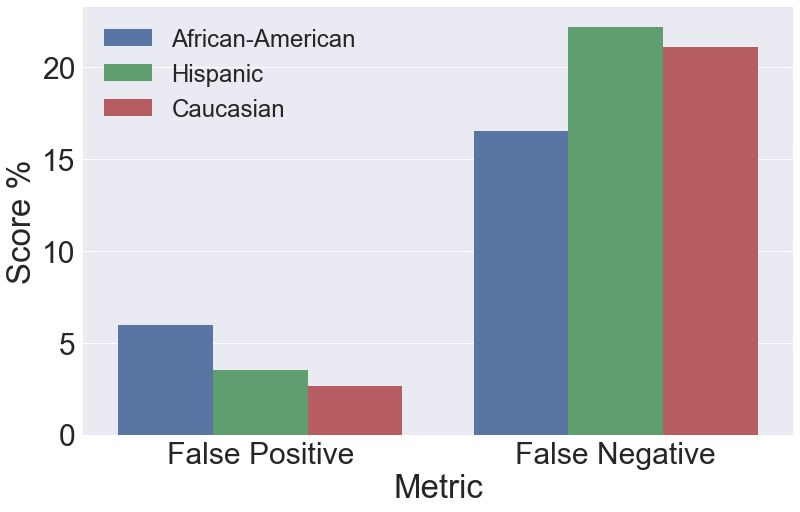

In [184]:
sb.set(font_scale=3)
ax = factorplot(x='Metric', y='Score %', hue='Race', data=x, kind='bar', size = 8, aspect = 1.5, 
                legend = False) 
plt.legend(loc='upper left', prop={'size': 24})
plt.show()

Group False Positive and Negative Precisions by race and plot

In [185]:
xx = x
xx['Metric'] = ['PPV','PPV','PPV','NPV','NPV','NPV']
xx['Score %'] = [aa_ppv,h_ppv,w_ppv,aa_npv,h_npv,w_npv]

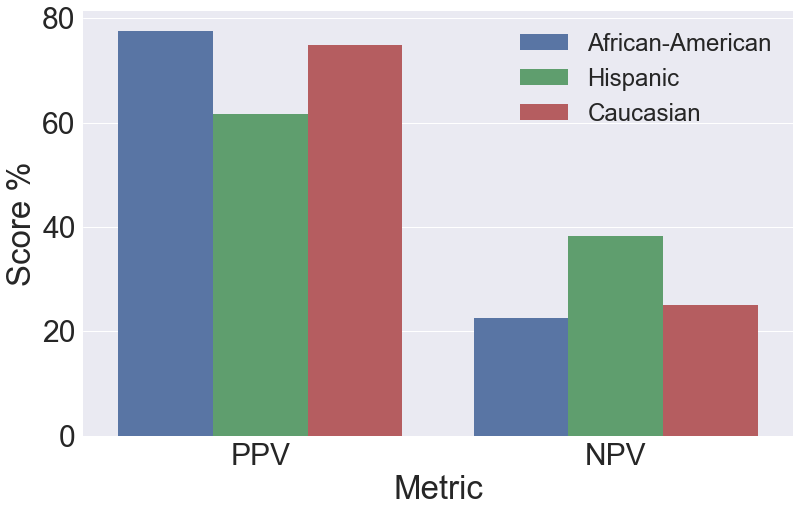

In [186]:
sb.set(font_scale=3)
ax = factorplot(x='Metric', y='Score %', hue='Race', data=xx, kind='bar', size = 8, aspect = 1.5, 
                legend = False) 
plt.legend(loc='upper right', prop={'size': 24})
plt.show()

Get the ROC and AUC values for the COMPAS prediction system, by race, and plot them

In [187]:
y_true = df['is_recid']
y_probas = df['decile_score']
fpr, tpr, thresholds = roc_curve(y_true, y_probas, pos_label=0)

In [188]:
afpr, atpr, athresholds = roc_curve(aa['is_recid'], aa['decile_score'], pos_label=0)
hfpr, htpr, hthresholds = roc_curve(h['is_recid'], h['decile_score'], pos_label=0)
wfpr, wtpr, wthresholds = roc_curve(w['is_recid'], w['decile_score'], pos_label=0)
aauc = np.trapz(afpr, atpr)
hauc = np.trapz(hfpr, htpr)
wauc = np.trapz(wfpr, wtpr)

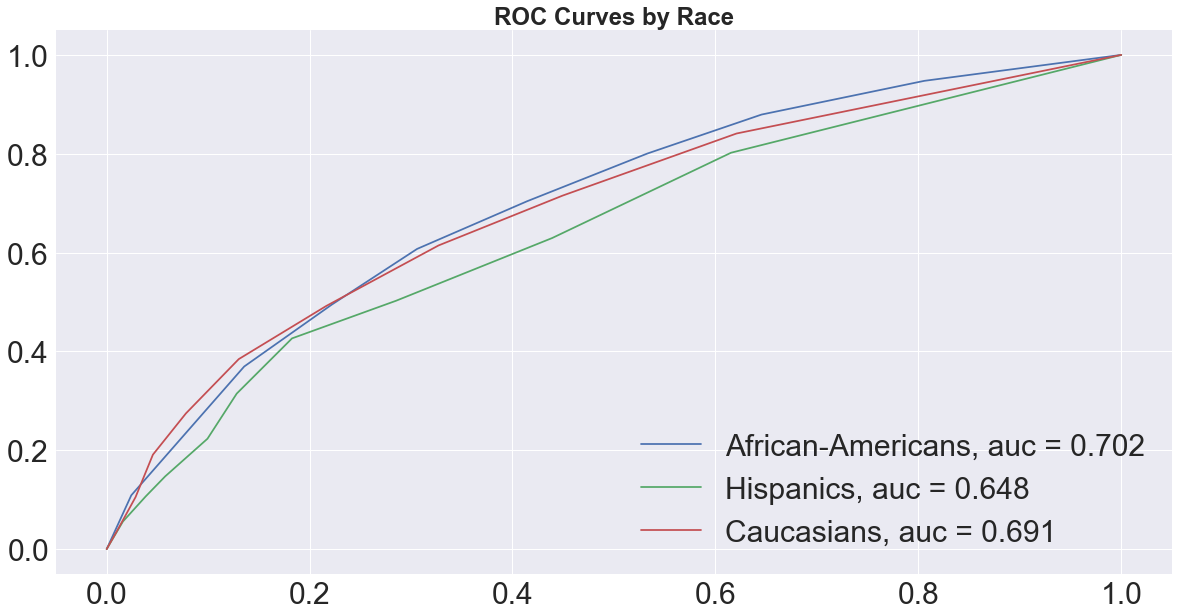

In [189]:
plt.figure(figsize=(20,10))
plt.plot(atpr,afpr,label="African-Americans, auc = "+str(round(aauc,3)))
plt.plot(htpr,hfpr,label="Hispanics, auc = "+ str(round(hauc,3)))
plt.plot(wtpr,wfpr,label="Caucasians, auc = "+ str(round(wauc,3)))
plt.title("ROC Curves by Race", fontsize = 24, fontweight= "bold")
plt.legend()
plt.show()

Firstly, the first plot (likelihood of recidivism by race) shows higher recidivism likelihoods for those rated as high and lower for those rated as low for all three races (for both normal and violent recidivism), as you would hopefully expect.  African-Americans do have slightly higher likelihoods than the other races, but it a a very small difference that I don't believe shows a statistical bias.  However, the next plot showing false positives and negatives tells a different story.  The African-American population experiences both a higher false positive rate (almost twice the rate of Caucasians and more than double of Hispanics) and lower false negative rate (~25% less than Caucasians and Hispanics).  This metric is the clear indicator that the system is biased (Blacks are gettting classified as a high risk when they don't recidivate compared to other races (FP), and the other races are getting classified as low/medium risk when they do recidivate higher than the black population (FN).  

The next plot (Positive/Negative Precision Values) show that the African-American population has the highest PPV - probability that the classification was correct.  This is the misleading statistic.  Although the precision was highest - the distribution the NPV (probaility of classifying incorrectly) was skewed towards a false positive (vs a false negative), which is certainly biased in this scenario.